<a href="https://colab.research.google.com/github/sksos7/Project/blob/main/Codestates_AI_05/Project_S_02/AI_05_%EC%9D%B4%EB%8F%99%EA%B7%9C_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Project Second






1. 데이터 선정 이유 및 문제 정의
 - 왜 해당 데이터를 선택했는지?
 - 어떤 유형의 문제로 (분류 / 회귀) 접근할지?
2. 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
 - 데이터를 통해서 내가 무엇을 해볼 수 있을지 가설을 세우는 것이 중요
 - 해당 특성을 target으로 지정한 이유를 설명하세요
 - 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요
3. EDA와 데이터 전처리
 - EDA, Feature Engineering, 데이터의 정규화, 노이즈 제거
 - 결측치 제거 혹은 대체,데이터 밸런스
 - Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?
 - 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?
4. 머신러닝 방식 적용 및 교차검증
 - 탐색과 전처리 작업이 끝났다면 모델링을 통해 베이스라인과의 성능 비교
 - Linear / Tree-based / Ensemble 모델을 학습
 - 평가지표를 계산 후 베이스라인과 비교
 - 교차 검증 (이하 CV)을 통해서 일반화될 가능성이 있는지 확인
 - 모델 성능을 개선하기 위한 다양한 방법을 적용 ( Hyperparameter tuning, etc. )
 - 최소 2개 이상의 모델을 만들어서 validation 점수를 보고
 - 최종 모델의 test 점수를 보고
 - 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는?
 - 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는?
 - 최종 모델에 관해 설명하세요.
5. 머신러닝 모델 해석
 - PDP, SHAP을 활용하여 최종 모델을 설명
 - 시각화는 "설명"이 제일 중요
 - 모델이 관측치를 예측하기 위해서 어떤 특성을 활용했나요?
 - 어떤 특성이 있다면 모델의 예측에 도움이 될까요? 해당 특성은 어떻게 구할 수 있을까요?





In [1]:
# 구글 드라이브로 접근
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5 # eli5 라이브러리 사용시
    !pip install pdpbox
    !pip install shap

In [3]:
# 사용할 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

import graphviz
from sklearn.tree import export_graphviz

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
ww = pd.read_csv('/content/drive/MyDrive/AI_05/S2/N2_Project/winequality-white.csv',sep=';')
rw = pd.read_csv('/content/drive/MyDrive/AI_05/S2/N2_Project/winequality-red.csv', sep=';')

1 - fixed acidity ( 결합산 )
 - 주로 타르타르산(tartaric),사과산(malic)으로 이루어져 있고
 와인의 산도를 제어 한다.

2 - volatile acidity ( 휘발산 )
 -  와인의 향에 연관이 많다. 

3 - citric acid ( 구연산 )
 - 와인의 신선함을 올려주는 역할, 산성화에 연관을 미친다

4 - residual sugar ( 잔여 설탕 )
 - 와인의 단맛을 올려준다. 

5 - chlorides ( 염화물 )
 - 와인의 짠맛의 원인이며 와인의 신맛을 좌우하는 성분

6 - free sulfur dioxide ( 유리 이산화황 )

7 - total sulfur dioxide ( 총 이산화황 )

8 - density ( 밀도 )
 - 바디의 높고 낮음을 표현하는 와인의 무게감을 의미한다.

9 - pH ( 산성도 )
 - 와인의 신맛의 정도를 나타낸다.

10 - sulphates ( 황산염 )
 -  황 화합물은 원하지 않는 박테리아와 효모를 죽여서 와인을 오래 보관하는 역할 

11 - alcohol ( 알코올 농도 )
 -  와인의 과 단맛을 주며 와인의 바디감에 영향을 준다.

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

Missing Attribute Values: None

In [5]:
ww.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
ww.shape, rw.shape

((4898, 12), (1599, 12))

In [8]:
# 1 - white, 0 - red
ww['Classification'] = 1
rw['Classification'] = 0
ww.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Classification
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


In [9]:
# 레드 or 화이트 분류 문제
df = pd.concat([ww,rw])

In [10]:
# 최빈값을 베이스 라인으로
df['Classification'].value_counts(normalize=True)

1    0.753886
0    0.246114
Name: Classification, dtype: float64

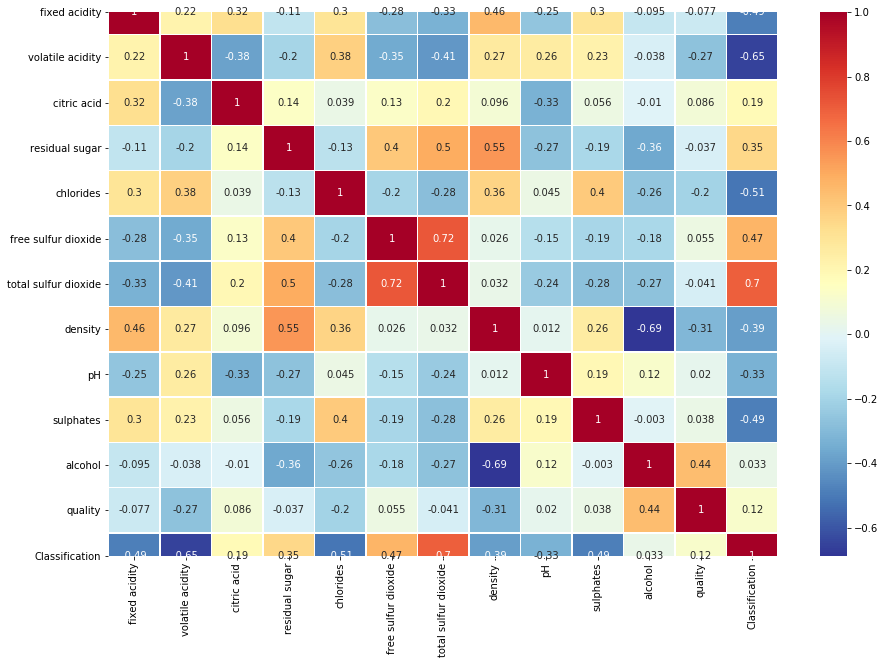

In [11]:
# 특성들 간의 상간관계
plt.subplots( figsize=(15,10) )
sns.heatmap(df.corr(), 
            cmap = 'RdYlBu_r',
            annot = True,
            linewidths=.5,
           );

In [12]:
# Classification 특성과 다른 특성들의 상간관계
pd.DataFrame(df.corr().unstack()['Classification'].sort_values(ascending=False), columns=['corr']).style.background_gradient(cmap='viridis')

,corr
Classification,1.000000
total sulfur dioxide,0.700357
free sulfur dioxide,0.471644
residual sugar,0.348821
citric acid,0.187397
quality,0.119323
alcohol,0.032970
pH,-0.329129
density,-0.390645
fixed acidity,-0.486740


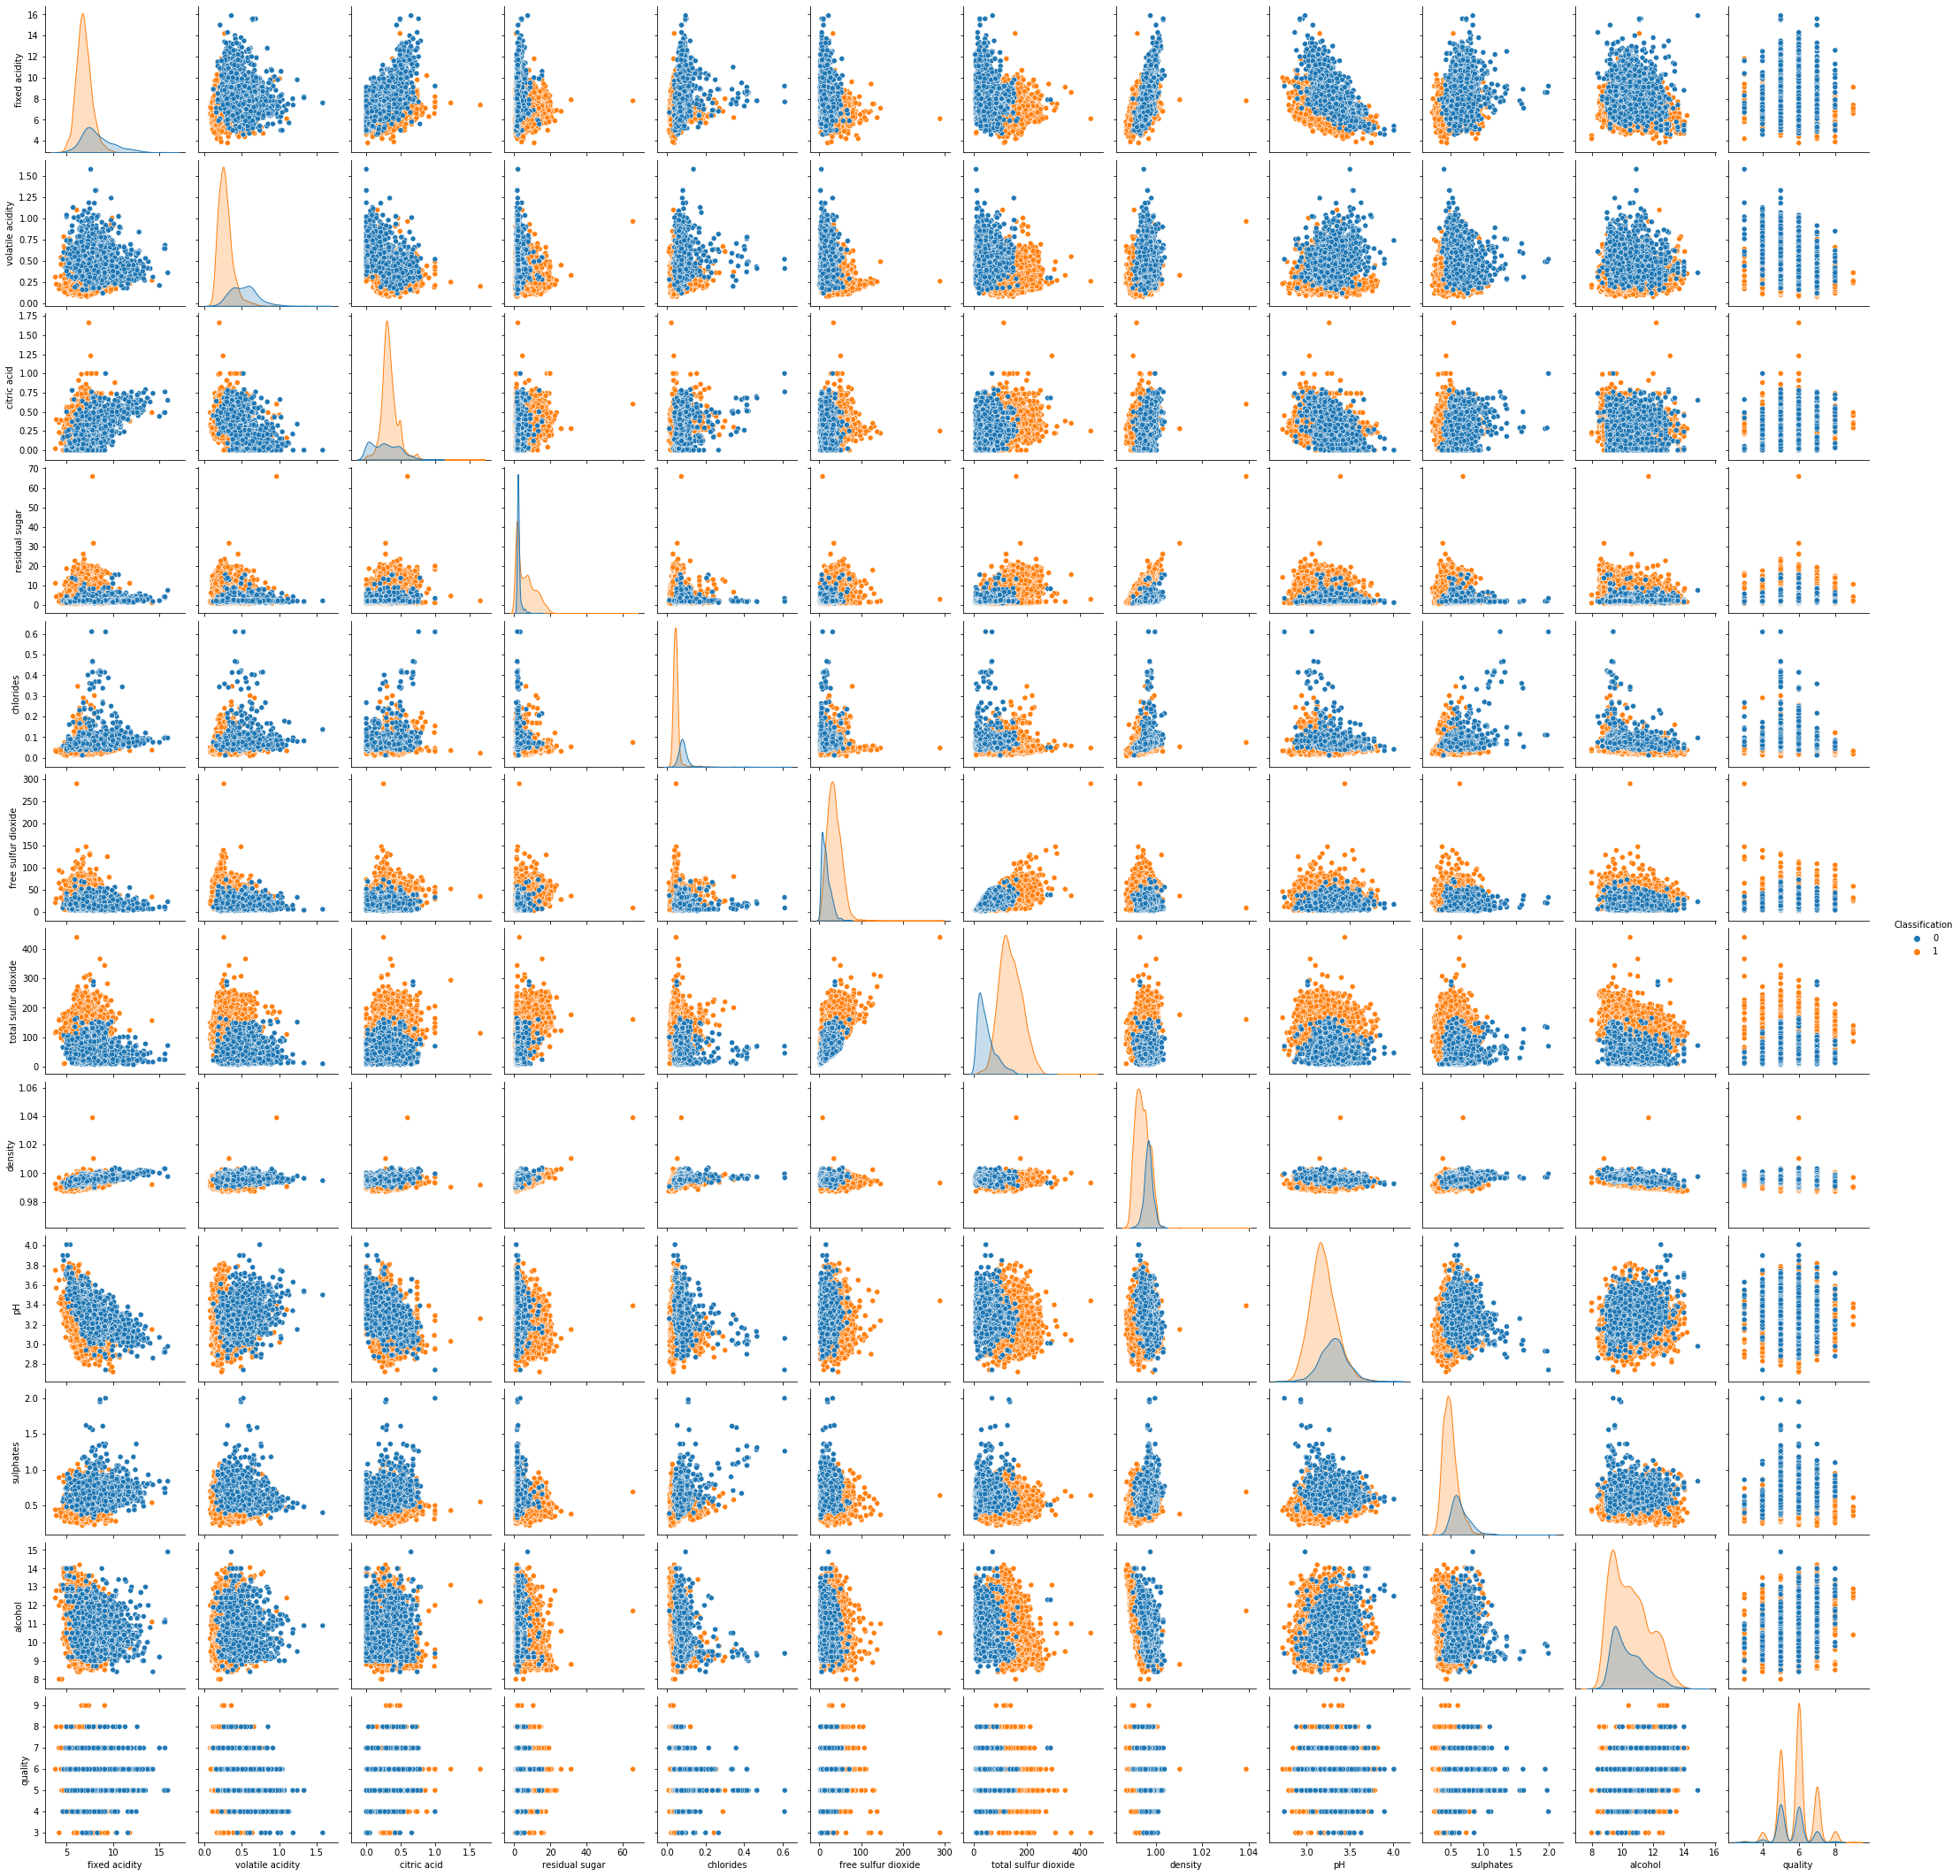

In [13]:
sns.pairplot(data=df,
             hue='Classification');

In [14]:
pd.concat([round(df[df['Classification'] == 0].describe(),2), round(df[df['Classification'] == 1].describe(),2)],
          axis=0,
          keys=['Red Wine', 'White Wine']).T

Red Wine                ... White Wine                
                        count   mean    std  ...        50%     75%     max
fixed acidity          1599.0   8.32   1.74  ...       6.80    7.30   14.20
volatile acidity       1599.0   0.53   0.18  ...       0.26    0.32    1.10
citric acid            1599.0   0.27   0.19  ...       0.32    0.39    1.66
residual sugar         1599.0   2.54   1.41  ...       5.20    9.90   65.80
chlorides              1599.0   0.09   0.05  ...       0.04    0.05    0.35
free sulfur dioxide    1599.0  15.87  10.46  ...      34.00   46.00  289.00
total sulfur dioxide   1599.0  46.47  32.90  ...     134.00  167.00  440.00
density                1599.0   1.00   0.00  ...       0.99    1.00    1.04
pH                     1599.0   3.31   0.15  ...       3.18    3.28    3.82
sulphates              1599.0   0.66   0.17  ...       0.47    0.55    1.08
alcohol                1599.0  10.42   1.07  ...      10.40   11.40   14.20
quality                1599.0   5.64   0.81  ...       6.00    6.00    9.00
Classification         1599.0   0.00   0.00  ...       1.00    1.00    1.00

[13 rows x 16 columns]


잔류 설탕, 총 이산화황 함량 = 화이트 >>>> 레드

황산염, 결합산, 휘발산 = 레드 > 화이트

구연산 = 화이트 > 레드

염소농도 = 레드 > 화이트 1/2

PH = 차이 미미


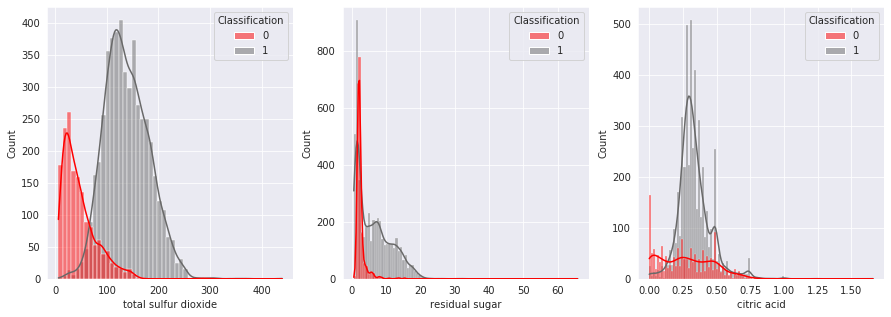

In [85]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(x="total sulfur dioxide", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[0] );
sns.histplot(x="residual sugar", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[1] );
sns.histplot(x="citric acid", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[2] );

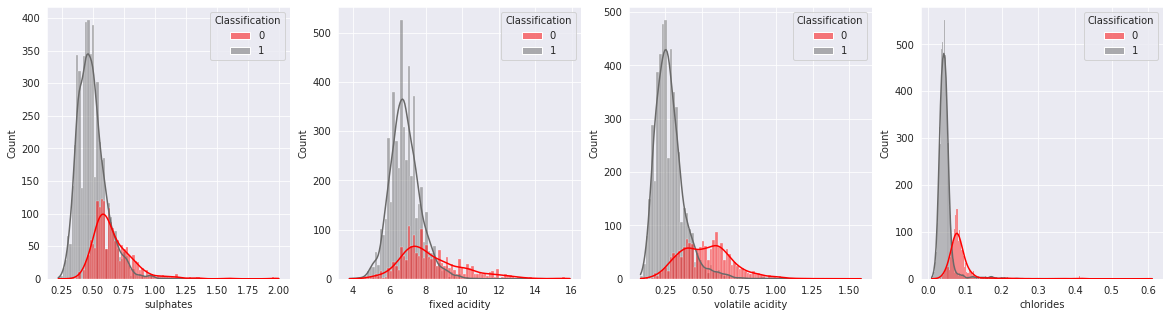

In [86]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.histplot(x="sulphates", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[0] );
sns.histplot(x="fixed acidity", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[1] );
sns.histplot(x="volatile acidity", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[2] );
sns.histplot(x="chlorides", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[3] );

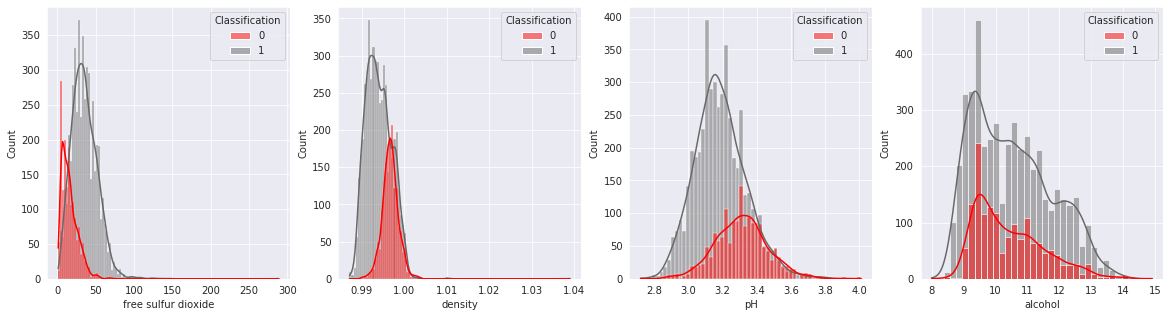

In [89]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.histplot(x="free sulfur dioxide", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[0] );
sns.histplot(x="density", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[1] );
sns.histplot(x="pH", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[2] );
sns.histplot(x="alcohol", hue="Classification", data=df, kde=True, palette=["r", "dimgrey"], ax=ax[3] );

In [15]:
# 결측치 확인
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Classification          0
dtype: int64

In [16]:
# 데이터 나누기
train, test = train_test_split(df, train_size=0.85, test_size=0.15, 
                              stratify=df['Classification'], shuffle=True,
                              random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Classification'], shuffle=True,
                              random_state=2)

train.shape, val.shape, test.shape

((4417, 13), (1105, 13), (975, 13))

In [17]:
# 타겟 데이터 나누기
X_train = train.drop('Classification', axis=1)
y_train = train['Classification']
X_val = val.drop('Classification', axis=1)
y_val = val['Classification']
X_test = test.drop('Classification', axis=1)
y_test = test['Classification']

X_train.shape, y_train.shape,\
X_val.shape, y_val.shape,\
X_test.shape, y_test.shape, 

((4417, 12), (4417,), (1105, 12), (1105,), (975, 12), (975,))

In [18]:
# 선형
pipe_linear = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
    )

pipe_linear.fit(X_train, y_train)
print('훈련 정확도: ', pipe_linear.score(X_train, y_train))
print('검증 정확도: ', pipe_linear.score(X_val, y_val))
print('검증 정확도: ', pipe_linear.score(X_test, y_test))

훈련 정확도:  0.8563732704334378
검증 정확도:  0.8832369919581144
검증 정확도:  0.8634525037960438


In [19]:
# 의사결정트리
pipe_decisiontree = make_pipeline(
    SimpleImputer(),
    StandardScaler(),    
    DecisionTreeClassifier()
    )

pipe_decisiontree.fit(X_train, y_train)
print('훈련 정확도: ', pipe_decisiontree.score(X_train, y_train))
print('검증 정확도: ', pipe_decisiontree.score(X_val, y_val))
print('검증 정확도: ', pipe_decisiontree.score(X_test, y_test))

훈련 정확도:  0.9997736019923025
검증 정확도:  0.983710407239819
검증 정확도:  0.9784615384615385


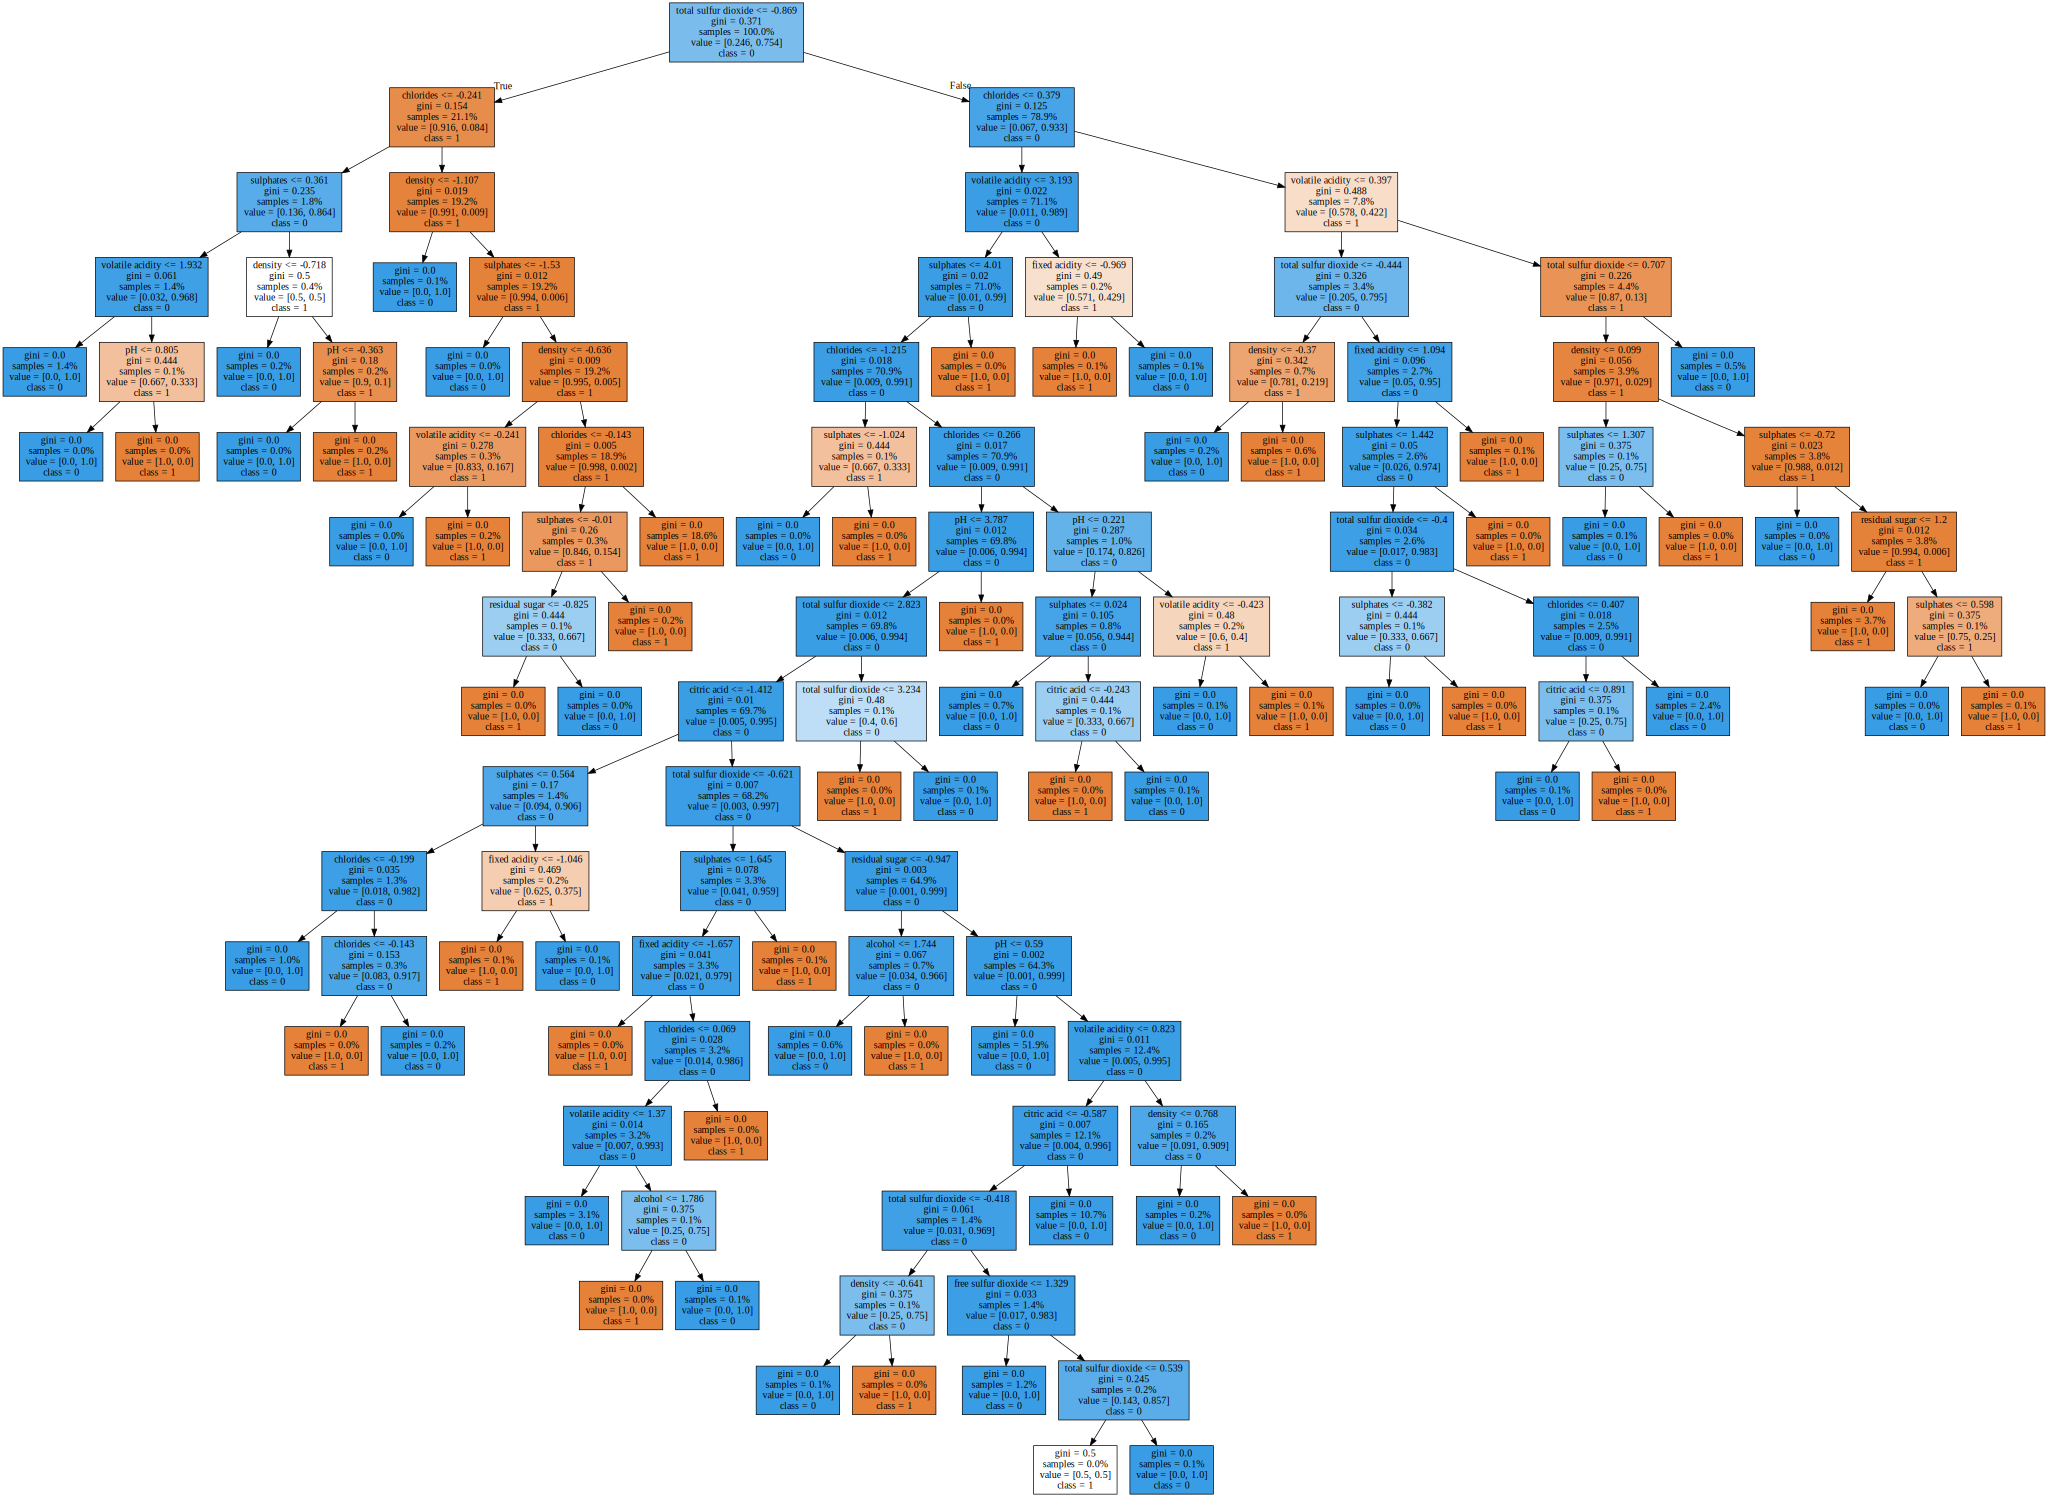

In [20]:
tree = pipe_decisiontree.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

In [21]:
# 랜덤포레스트(앙상블)
pipe_randomfo = make_pipeline(
    SimpleImputer(),
    StandardScaler(),    
    RandomForestClassifier(random_state=2)
    )

pipe_randomfo.fit(X_train, y_train)
print('훈련 정확도: ', pipe_randomfo.score(X_train, y_train))
print('검증 정확도: ', pipe_randomfo.score(X_val, y_val))
print('검증 정확도: ', pipe_randomfo.score(X_test, y_test))

훈련 정확도:  0.9997736019923025
검증 정확도:  0.9972850678733032
검증 정확도:  0.9917948717948718


In [22]:
# 교차 검증
k = 10
scores = cross_val_score(pipe_randomfo, df.drop('Classification',axis=1), df['Classification'], cv=k, 
                         scoring='f1')

print(f'{k} folds:', scores)

10 folds: [1.         0.99592668 0.99795918 0.9969419  0.99796334 0.99591837
 0.9928934  0.9908999  0.99897855 0.99795918]


In [23]:
dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': range(1,100), 
    'randomforestclassifier__max_depth': range(1,50), 
    'randomforestclassifier__min_samples_split': range(1,50), 
    'randomforestclassifier__min_samples_leaf': range(1,50), 
    'randomforestclassifier__max_features': range(1,12), 
    'randomforestclassifier__max_leaf_nodes': range(1,50), 
}

clf = RandomizedSearchCV(
    pipe_randomfo, 
    param_distributions=dists, 
    n_iter=100, 
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.4s finished


In [24]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('F1: ', clf.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 67, 'randomforestclassifier__min_samples_split': 11, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_leaf_nodes': 33, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__max_depth': 39}
F1:  0.9940158122704448


In [25]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,56,2,27,91,90,1,7,43,36,26,54,38,79,70,32,58,85,82,24,72,69,49,73,22,75,84,15,83,74,42,65,88,46,41,77,18,89,55,28,48,...,31,17,57,33,50,81,97,51,21,67,16,0,86,92,68,3,44,37,78,25,99,64,12,63,34,4,39,6,96,14,76,47,98,13,40,53,30,94,95,9
mean_fit_time,0.541501,0.34163,0.275064,0.076431,0.832262,0.585675,0.613918,0.472745,0.225235,0.16459,0.393028,0.400956,0.200745,0.350191,0.11261,0.131683,0.452643,0.555627,0.238335,0.136766,0.155987,0.501173,0.162726,0.330805,0.161882,0.0878394,0.275255,0.403322,0.431811,0.371438,0.43296,0.196908,0.597003,0.705303,0.580153,0.34084,0.0566381,0.0587523,0.197354,0.195368,...,0.299736,0.0392961,0.944613,0.0942481,0.233829,0.311459,0.370318,0.248282,0.0822274,0.895104,0.858727,0.150634,0.0574921,0.290921,0.748534,0.475326,0.512982,0.608759,0.554827,0.29312,0.3284,0.0356838,0.0296241,0.698843,0.0667237,0.0280658,0.0431128,0.309728,0.274353,0.0935946,0.176313,0.187529,0.214462,0.0431024,0.0355158,0.0544074,0.0583248,0.0380851,0.0186321,0.0243426
std_fit_time,0.00974497,0.00201557,0.00614862,0.00431777,0.0347416,0.00878277,0.0153885,0.0182305,0.00770511,0.00431871,0.00850394,0.00608429,0.00573142,0.00423614,0.00309652,0.00137711,0.0160042,0.00766536,0.00296473,0.00466029,0.00312551,0.0074022,0.00299744,0.0036594,0.000731253,0.00126318,0.0030744,0.00349161,0.0145275,0.00422847,0.00425616,0.00976216,0.0212873,0.0047036,0.0124472,0.00754776,0.00135888,0.00348069,0.00406597,0.00204873,...,0.00835242,0.00487398,0.00534939,0.0044264,0.00442727,0.00542475,0.00719284,0.0083519,0.00136908,0.0209883,0.0149415,0.00980042,0.00112314,0.00729025,0.023517,0.00992294,0.00833704,0.0187905,0.00439759,0.00618229,0.0282271,0.000986558,0.000351561,0.00532753,0.00322154,0.000421354,0.00361789,0.00638515,0.00576906,0.00774494,0.00251627,0.00573962,0.00636242,0.00190725,0.00506491,0.00628988,0.00288769,0.00806112,0.00366229,0.000826465
mean_score_time,0.0248698,0.0262608,0.025565,0.00863783,0.0273201,0.0304883,0.0333652,0.0155492,0.010078,0.0119967,0.0240519,0.0305926,0.0145791,0.0246705,0.00942715,0.0117743,0.0283323,0.0303187,0.0101848,0.00967622,0.0128983,0.0363644,0.0115928,0.0331443,0.0157322,0.00793982,0.0199664,0.0248486,0.0285831,0.0150576,0.0191157,0.0203134,0.0238126,0.0263893,0.0292644,0.0281163,0.00685382,0.00778627,0.0137279,0.0173859,...,0.029397,0.00581781,0.0283955,0.00963672,0.0206168,0.0152887,0.0178231,0.0173623,0.00706911,0.0305187,0.031546,0.00958657,0.00765379,0.0170935,0.0253806,0.0277545,0.0189512,0.0235829,0.0278621,0.0134215,0.0118535,0.00557113,0.00601014,0.0276414,0.00782943,0.00532357,0.00818912,0.0262001,0.0200615,0.010365,0.0175456,0.0177569,0.0143713,0.00646766,0,0,0,0,0,0
std_score_time,0.00133808,0.00097278,0.00458237,0.000100471,0.000864744,0.00125568,0.00143194,0.000782864,0.000364996,0.000340839,0.000959487,0.00455012,0.000148945,0.00142682,0.000183431,0.000779898,0.00172689,0.000597154,9.94754e-05,0.000360112,0.000257335,0.00439645,0.000135395,0.00158948,0.00134121,0.000203921,0.00125647,0.00159279,0.00262576,6.4456e-05,0.000367411,0.00143554,0.00130053,0.00216655,0.00111048,0.000503866,0.000429628,0.000236498,0.000264402,0.00396855,...,0.00112254,0.000108062,8.5248e-05,8.13154e-05,0.00379258,0.000398405,0.000179072,0.00429517,5.20106e-05,0.00224803,0.000996171,0.00042572,5.26592e-05,0.00049925,0.000170966,0.000886098,0.000486011,0.00102805,0.000926633,0.000102775,0.00189258,9.22728e-05,0.000145641,0.000352323,0.000246123,1.08811e-05,0.00033768,0.00171136,0.00272786,0.000305341,0.000551712,0.000624672,0.000471184,7.45917e-05,0,0,0,0,0,0
param_simpleimputer__strategy,median,median,mean,median,median,median,median,mean,mean,mean,median,median,median,mean,mean,mean,median,median,mean,median,median,mean,mean,mean,median,mean,mean,median,mean,median,median,median,median,mean,mean,median,median,median,median,mean,...,mean,median,mean,median,median,mean,mean,median,median,median,median,mean,median,median,median,mean,median,median,mean,median,mean,median,mean,median,mean,median,mean,mean,mean,me

In [26]:
pipe_randomfo = clf.best_estimator_

In [27]:
y_pred = pipe_randomfo.predict(X_train)
print('훈련 정확도: ', f1_score(y_train, y_pred))
y_pred = pipe_randomfo.predict(X_val)
print('검증 정확도: ', f1_score(y_val, y_pred))
y_pred = pipe_randomfo.predict(X_test)
print('테스트 정확도: ', f1_score(y_test, y_pred))

훈련 정확도:  0.9964071856287425
검증 정확도:  0.9975990396158463
테스트 정확도:  0.9891598915989159


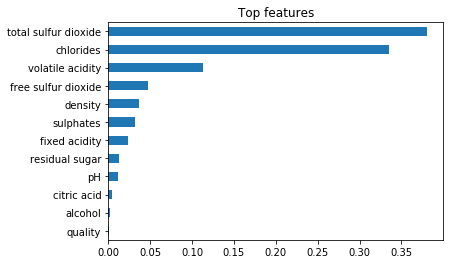

In [28]:
# 특성 중요도
rf = pipe_randomfo.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

plt.title(f'Top features')
importances.sort_values().plot.barh();

In [29]:
# permuter 정의
permuter = PermutationImportance(
    pipe_randomfo.named_steps['randomforestclassifier'], # model
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = pipe_randomfo.named_steps['standardscaler'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [30]:
permuter.feature_importances_

array([0.00191645, 0.0090241 , 0.00119602, 0.0014377 , 0.04210666,
       0.        , 0.09061176, 0.00715843, 0.00203154, 0.0046481 ,
       0.00035906, 0.        ])

In [31]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

free sulfur dioxide     0.000000
quality                 0.000000
alcohol                 0.000359
citric acid             0.001196
residual sugar          0.001438
fixed acidity           0.001916
pH                      0.002032
sulphates               0.004648
density                 0.007158
volatile acidity        0.009024
chlorides               0.042107
total sulfur dioxide    0.090612
dtype: float64

In [32]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0906 ± 0.0104,total sulfur dioxide
0.0421 ± 0.0039,chlorides
0.0090 ± 0.0023,volatile acidity
0.0072 ± 0.0013,density
0.0046 ± 0.0029,sulphates
0.0020 ± 0.0010,pH
0.0019 ± 0.0012,fixed acidity
0.0014 ± 0.0010,residual sugar
0.0012 ± 0.0008,citric acid
0.0004 ± 0.0006,alcohol


In [33]:
pipe_randomfo.fit(X_train, y_train)
print('검증 정확도', pipe_randomfo.score(X_val, y_val))

print(classification_report(y_val, pipe_randomfo.predict(X_val)))

검증 정확도 0.9963800904977376
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       272
           1       1.00      1.00      1.00       833

    accuracy                           1.00      1105
   macro avg       1.00      1.00      1.00      1105
weighted avg       1.00      1.00      1.00      1105



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


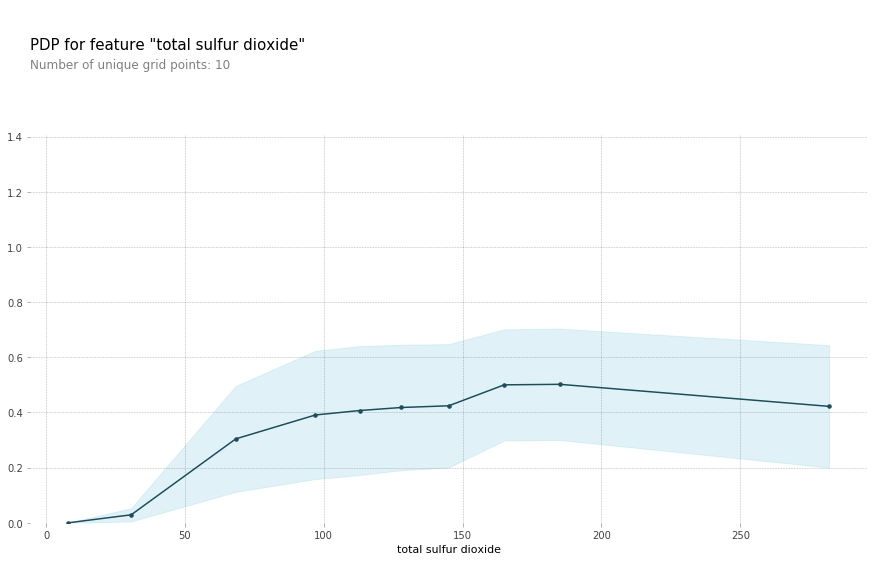

In [34]:
isolated = pdp_isolate(
    model=pipe_randomfo, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature='total sulfur dioxide',
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
);
pdp_plot(isolated, 'total sulfur dioxide');

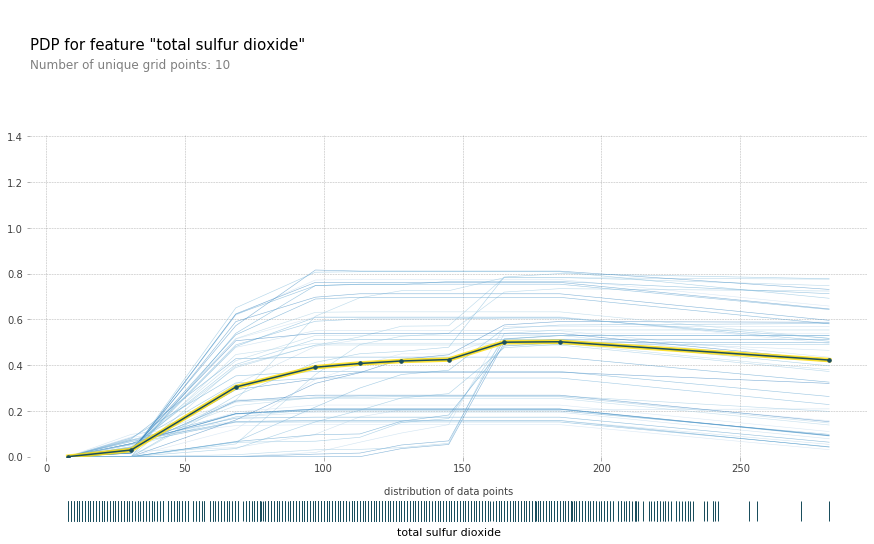

In [35]:
pdp_plot(isolated
         , feature_name='total sulfur dioxide'
         , plot_lines=True # ICE plots
         , frac_to_plot=0.05 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True);


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


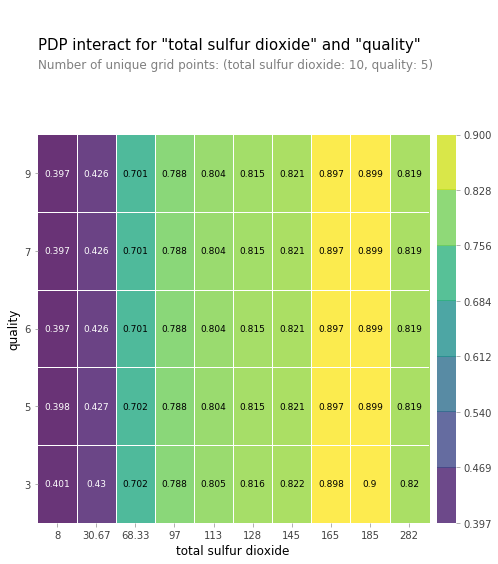

In [36]:
features = ['total sulfur dioxide', 'quality']

interaction = pdp_interact(
    model=pipe_randomfo, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
);

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [37]:
test = df[['Classification']]
test

,Classification
0,1
1,1
2,1
3,1
4,1
...,...
1594,0
1595,0
1596,0
1597,0
